# Modelling Suara Buka Tutup & Deployment

## 1: Import Libraries & Load Data
Mengimpor library machine learning dan memuat data training/validation yang sudah diproses dari file numpy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Modeling libraries imported successfully!")

# Load data fitur yang sudah dibersihkan
try:
    df_features = pd.read_csv('audio_features_clean.csv')
    print(f"📊 Loaded feature dataset: {df_features.shape}")
    print(f"Columns: {list(df_features.columns[:10])}...")  # Tampilkan 10 kolom pertama
except:
    print("❌ Cannot load features file. Please run feature extraction first.")
    df_features = None

if df_features is not None:
    print("\n📈 Dataset Info:")
    print(f"Total samples: {len(df_features)}")
    print(f"Persons: {df_features['person'].unique()}")
    print(f"Commands: {df_features['command'].unique()}")
    print(f"Split distribution:\n{df_features['split'].value_counts()}")

✅ Modeling libraries imported successfully!
📊 Loaded feature dataset: (1480, 92)
Columns: ['rms_energy', 'zcr', 'energy_entropy', 'mean', 'std', 'skewness', 'kurtosis', 'max_amp', 'min_amp', 'range_amp']...

📈 Dataset Info:
Total samples: 1480
Persons: ['ardi' 'asep']
Commands: ['buka' 'tutup']
Split distribution:
split
train    1400
val        80
Name: count, dtype: int64


PISAHKAN LABEL

In [2]:
def prepare_features_and_labels(df):
    """
    Siapkan fitur dan label untuk training dan validation
    """
    # Filter kolom fitur (exclude metadata)
    feature_columns = [col for col in df.columns if col not in 
                      ['split', 'person', 'command', 'file', 'is_augmented']]
    
    print(f"🎯 Using {len(feature_columns)} features for modeling")
    
    # Pisahkan data train dan validation
    train_data = df[df['split'] == 'train']
    val_data = df[df['split'] == 'val']
    
    print(f"📚 Training samples: {len(train_data)}")
    print(f"🧪 Validation samples: {len(val_data)}")
    
    # Prepare features and labels untuk berbagai skenario
    scenarios = {
        'person_identification': {
            'train_X': train_data[feature_columns],
            'train_y': train_data['person'],
            'val_X': val_data[feature_columns],
            'val_y': val_data['person'],
            'description': 'Identify Person (Asep vs Ardi)'
        },
        'command_identification': {
            'train_X': train_data[feature_columns],
            'train_y': train_data['command'],
            'val_X': val_data[feature_columns],
            'val_y': val_data['command'],
            'description': 'Identify Command (Buka vs Tutup)'
        },
        'combined_identification': {
            'train_X': train_data[feature_columns],
            'train_y': train_data['person'] + '_' + train_data['command'],
            'val_X': val_data[feature_columns],
            'val_y': val_data['person'] + '_' + val_data['command'],
            'description': 'Combined (Person + Command)'
        }
    }
    
    return scenarios, feature_columns

if df_features is not None:
    scenarios, feature_columns = prepare_features_and_labels(df_features)
    
    # Tampilkan distribusi label
    for scenario_name, scenario_data in scenarios.items():
        print(f"\n📊 {scenario_data['description']}:")
        print(f"Train labels: {pd.Series(scenario_data['train_y']).value_counts().to_dict()}")
        print(f"Val labels: {pd.Series(scenario_data['val_y']).value_counts().to_dict()}")

🎯 Using 87 features for modeling
📚 Training samples: 1400
🧪 Validation samples: 80

📊 Identify Person (Asep vs Ardi):
Train labels: {'ardi': 700, 'asep': 700}
Val labels: {'ardi': 40, 'asep': 40}

📊 Identify Command (Buka vs Tutup):
Train labels: {'buka': 700, 'tutup': 700}
Val labels: {'buka': 40, 'tutup': 40}

📊 Combined (Person + Command):
Train labels: {'ardi_buka': 350, 'ardi_tutup': 350, 'asep_buka': 350, 'asep_tutup': 350}
Val labels: {'ardi_buka': 20, 'ardi_tutup': 20, 'asep_buka': 20, 'asep_tutup': 20}


MEMBUAT MODEL LATIH RANDOM FOREST

In [3]:
def train_and_evaluate_models(scenarios, feature_columns):
    """
    Train dan evaluate multiple models untuk setiap skenario
    """
    results = {}
    models = {
        'SVM': SVC(kernel='rbf', C=1.0, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'GradientBoosting': GradientBoostingClassifier(random_state=42)
    }
    
    for scenario_name, scenario_data in scenarios.items():
        print(f"\n🎯 Training models for: {scenario_data['description']}")
        print("=" * 50)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(scenario_data['train_X'])
        X_val_scaled = scaler.transform(scenario_data['val_X'])
        
        # Encode labels
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(scenario_data['train_y'])
        y_val_encoded = le.transform(scenario_data['val_y'])
        
        scenario_results = {}
        
        for model_name, model in models.items():
            print(f"🔄 Training {model_name}...")
            
            # Train model
            model.fit(X_train_scaled, y_train_encoded)
            
            # Predict
            y_pred = model.predict(X_val_scaled)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_val_encoded, y_pred)
            
            scenario_results[model_name] = {
                'model': model,
                'scaler': scaler,
                'label_encoder': le,
                'accuracy': accuracy,
                'predictions': y_pred,
                'true_labels': y_val_encoded
            }
            
            print(f"✅ {model_name} Accuracy: {accuracy:.4f}")
        
        # Find best model
        best_model_name = max(scenario_results, key=lambda x: scenario_results[x]['accuracy'])
        best_accuracy = scenario_results[best_model_name]['accuracy']
        
        print(f"\n🏆 Best model for {scenario_data['description']}: {best_model_name} (Accuracy: {best_accuracy:.4f})")
        
        results[scenario_name] = {
            'scenario_data': scenario_data,
            'models': scenario_results,
            'best_model': best_model_name,
            'feature_columns': feature_columns
        }
    
    return results

if df_features is not None:
    results = train_and_evaluate_models(scenarios, feature_columns)


🎯 Training models for: Identify Person (Asep vs Ardi)
🔄 Training SVM...
✅ SVM Accuracy: 1.0000
🔄 Training KNN...
✅ KNN Accuracy: 1.0000
🔄 Training LogisticRegression...
✅ LogisticRegression Accuracy: 1.0000
🔄 Training GradientBoosting...
✅ GradientBoosting Accuracy: 1.0000

🏆 Best model for Identify Person (Asep vs Ardi): SVM (Accuracy: 1.0000)

🎯 Training models for: Identify Command (Buka vs Tutup)
🔄 Training SVM...
✅ SVM Accuracy: 0.8375
🔄 Training KNN...
✅ KNN Accuracy: 0.8625
🔄 Training LogisticRegression...
✅ LogisticRegression Accuracy: 0.8125
🔄 Training GradientBoosting...
✅ GradientBoosting Accuracy: 0.8625

🏆 Best model for Identify Command (Buka vs Tutup): KNN (Accuracy: 0.8625)

🎯 Training models for: Combined (Person + Command)
🔄 Training SVM...
✅ SVM Accuracy: 0.8500
🔄 Training KNN...
✅ KNN Accuracy: 0.8625
🔄 Training LogisticRegression...
✅ LogisticRegression Accuracy: 0.8125
🔄 Training GradientBoosting...
✅ GradientBoosting Accuracy: 0.8625

🏆 Best model for Combined (

evaluasi model data validation

In [4]:
def detailed_validation_evaluation(results):
    """
    Evaluasi detail untuk setiap skenario di data validation
    """
    for scenario_name, scenario_result in results.items():
        scenario_data = scenario_result['scenario_data']
        best_model_name = scenario_result['best_model']
        best_model_info = scenario_result['models'][best_model_name]
        
        print(f"\n{'='*60}")
        print(f"📊 DETAILED EVALUATION: {scenario_data['description']}")
        print(f"🏆 Best Model: {best_model_name}")
        print(f"{'='*60}")
        
        # Classification report
        y_true = best_model_info['true_labels']
        y_pred = best_model_info['predictions']
        le = best_model_info['label_encoder']
        
        class_names = le.classes_
        
        print(f"🎯 Accuracy: {best_model_info['accuracy']:.4f}")
        print(f"\n📋 Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        # Cross-validation scores
        scaler = best_model_info['scaler']
        model = best_model_info['model']
        
        X_scaled = scaler.transform(scenario_data['train_X'][scenario_result['feature_columns']])
        y_encoded = le.transform(scenario_data['train_y'])
        
        cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')
        print(f"📊 Cross-Validation Scores: {cv_scores}")
        print(f"📊 CV Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Per-class accuracy
        print(f"\n🎯 Per-class Accuracy:")
        cm = confusion_matrix(y_true, y_pred)
        per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
        
        for i, class_name in enumerate(class_names):
            print(f"  {class_name}: {per_class_accuracy[i]:.4f}")

if df_features is not None:
    detailed_validation_evaluation(results)


📊 DETAILED EVALUATION: Identify Person (Asep vs Ardi)
🏆 Best Model: SVM
🎯 Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

        ardi       1.00      1.00      1.00        40
        asep       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

📊 Cross-Validation Scores: [1. 1. 1. 1. 1.]
📊 CV Mean Accuracy: 1.0000 (+/- 0.0000)

🎯 Per-class Accuracy:
  ardi: 1.0000
  asep: 1.0000

📊 DETAILED EVALUATION: Identify Command (Buka vs Tutup)
🏆 Best Model: KNN
🎯 Accuracy: 0.8625

📋 Classification Report:
              precision    recall  f1-score   support

        buka       0.89      0.82      0.86        40
       tutup       0.84      0.90      0.87        40

    accuracy                           0.86        80
   macro avg       0.86      0.86      0.86        80
weighted avg       0.86   

confusion matrix

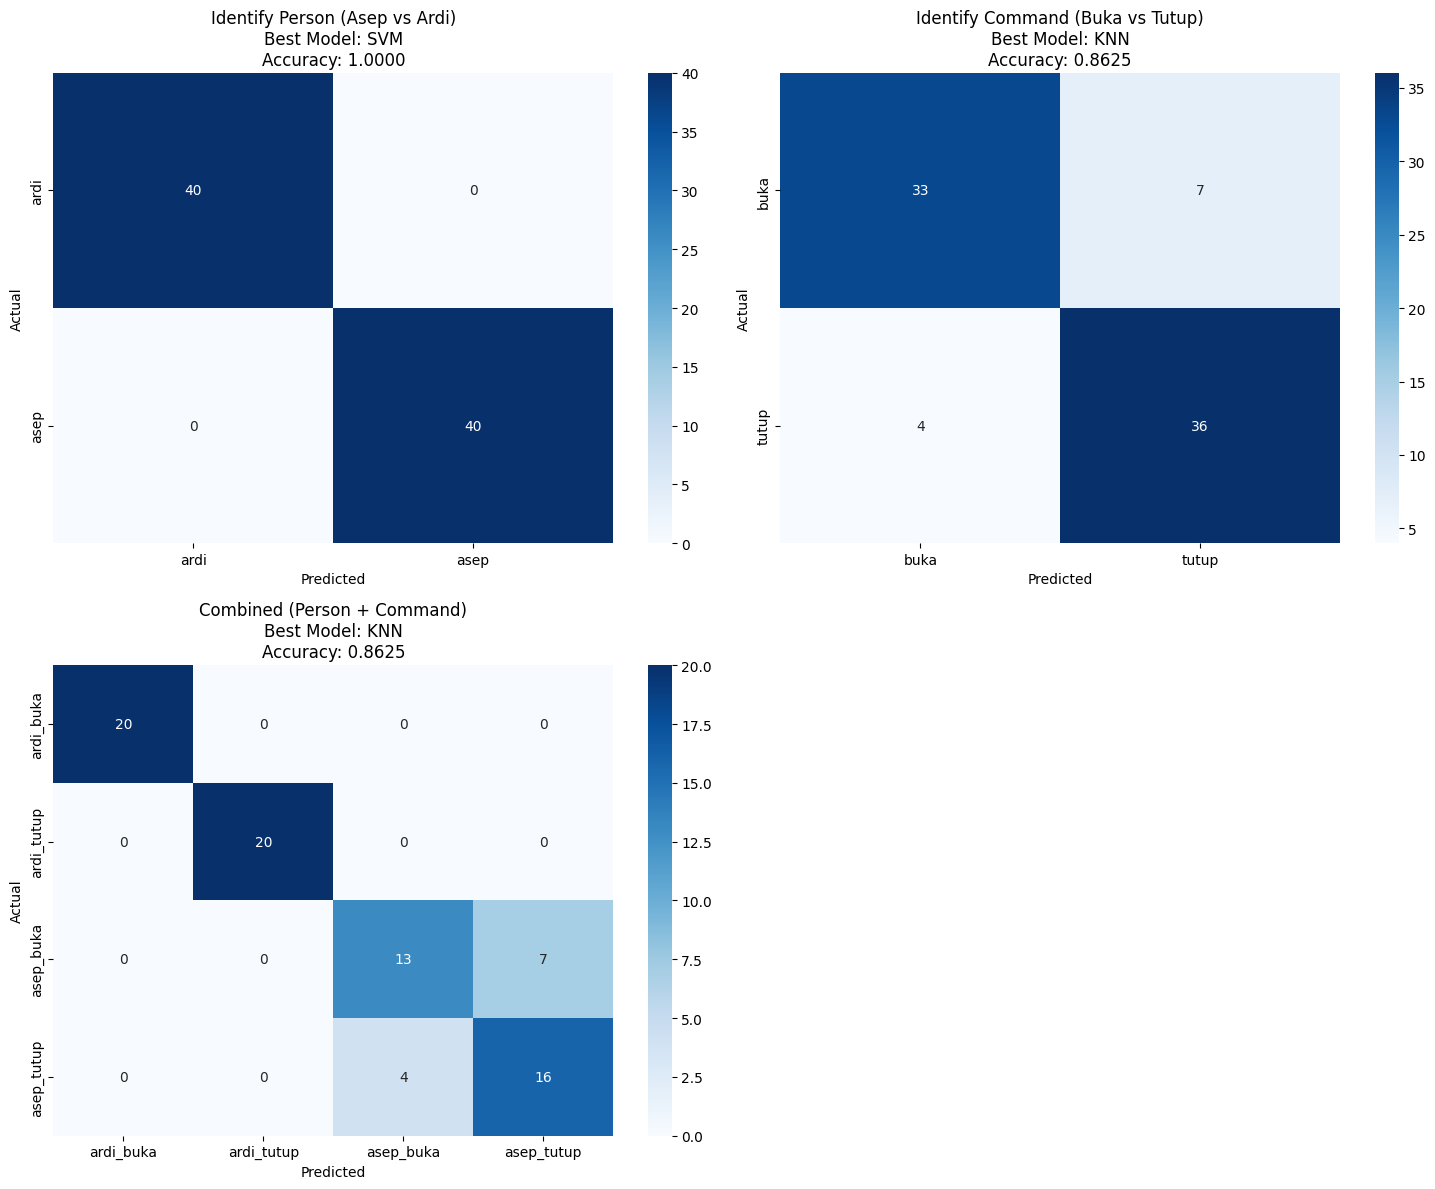

In [5]:
def plot_confusion_matrices(results):
    """
    Plot confusion matrix untuk setiap skenario
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (scenario_name, scenario_result) in enumerate(results.items()):
        if idx >= 4:  # Max 4 plots
            break
            
        best_model_name = scenario_result['best_model']
        best_model_info = scenario_result['models'][best_model_name]
        
        y_true = best_model_info['true_labels']
        y_pred = best_model_info['predictions']
        le = best_model_info['label_encoder']
        class_names = le.classes_
        
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx])
        
        axes[idx].set_title(f'{scenario_result["scenario_data"]["description"]}\n'
                           f'Best Model: {best_model_name}\n'
                           f'Accuracy: {best_model_info["accuracy"]:.4f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # Hide unused subplots
    for idx in range(len(results), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

if df_features is not None:
    plot_confusion_matrices(results)

fitur importance

🔍 FEATURE IMPORTANCE ANALYSIS

📊 Scenario: Identify Person (Asep vs Ardi)

🏆 LogisticRegression - Top 10 Features (Absolute Coefficients):
           feature  importance
19      mfcc_1_max    0.547843
26      mfcc_3_min    0.488701
70        chroma_3    0.427440
50      mfcc_9_min    0.420439
38      mfcc_6_min    0.415648
6         kurtosis    0.401279
24     mfcc_3_mean    0.388018
27      mfcc_3_max    0.361758
2   energy_entropy    0.356192
5         skewness    0.344096

🏆 GradientBoosting - Top 10 Features:
        feature  importance
48  mfcc_9_mean    0.271460
8       min_amp    0.220926
63  mfcc_12_max    0.101959
3          mean    0.067998
27   mfcc_3_max    0.034788
26   mfcc_3_min    0.030129
19   mfcc_1_max    0.022892
38   mfcc_6_min    0.022820
18   mfcc_1_min    0.020339
81      rms_std    0.017360


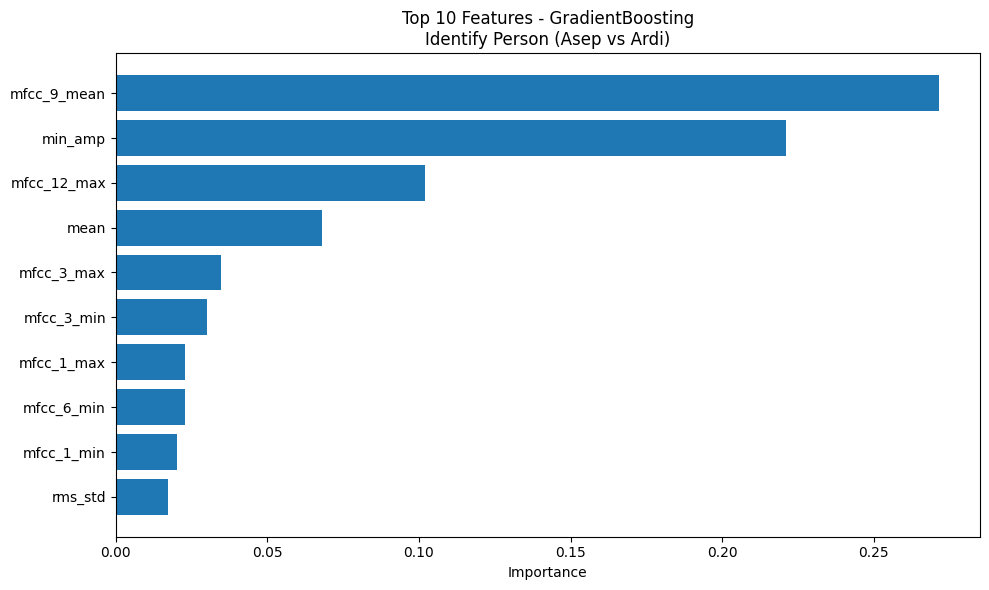


📊 Scenario: Identify Command (Buka vs Tutup)

🏆 LogisticRegression - Top 10 Features (Absolute Coefficients):
           feature  importance
19      mfcc_1_max    0.547843
26      mfcc_3_min    0.488701
70        chroma_3    0.427440
50      mfcc_9_min    0.420439
38      mfcc_6_min    0.415648
6         kurtosis    0.401279
24     mfcc_3_mean    0.388018
27      mfcc_3_max    0.361758
2   energy_entropy    0.356192
5         skewness    0.344096

🏆 GradientBoosting - Top 10 Features:
        feature  importance
48  mfcc_9_mean    0.271460
8       min_amp    0.220926
63  mfcc_12_max    0.101959
3          mean    0.067998
27   mfcc_3_max    0.034788
26   mfcc_3_min    0.030129
19   mfcc_1_max    0.022892
38   mfcc_6_min    0.022820
18   mfcc_1_min    0.020339
81      rms_std    0.017360


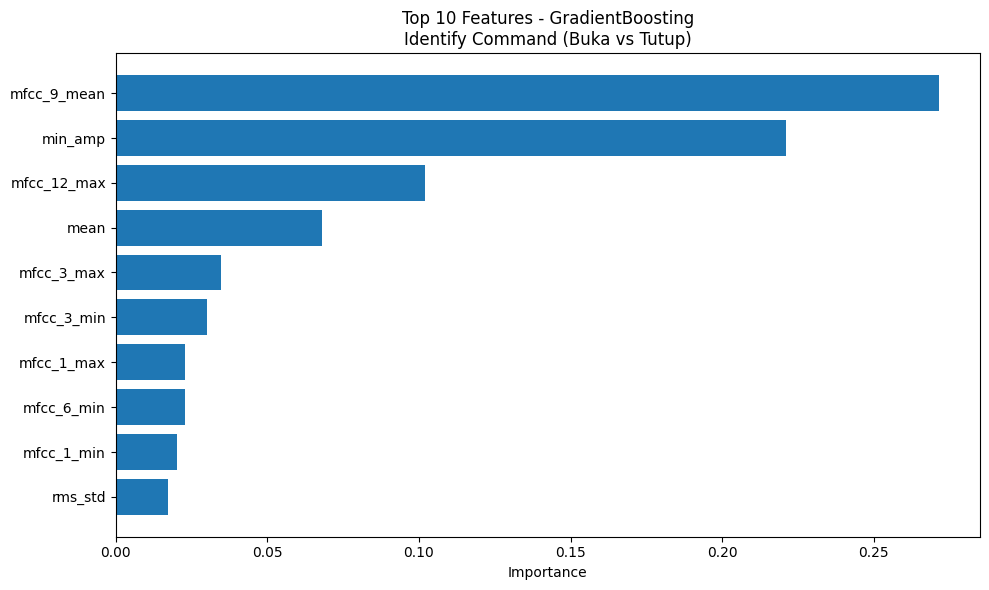


📊 Scenario: Combined (Person + Command)

🏆 LogisticRegression - Top 10 Features (Absolute Coefficients):
           feature  importance
19      mfcc_1_max    0.547843
26      mfcc_3_min    0.488701
70        chroma_3    0.427440
50      mfcc_9_min    0.420439
38      mfcc_6_min    0.415648
6         kurtosis    0.401279
24     mfcc_3_mean    0.388018
27      mfcc_3_max    0.361758
2   energy_entropy    0.356192
5         skewness    0.344096

🏆 GradientBoosting - Top 10 Features:
        feature  importance
48  mfcc_9_mean    0.271460
8       min_amp    0.220926
63  mfcc_12_max    0.101959
3          mean    0.067998
27   mfcc_3_max    0.034788
26   mfcc_3_min    0.030129
19   mfcc_1_max    0.022892
38   mfcc_6_min    0.022820
18   mfcc_1_min    0.020339
81      rms_std    0.017360


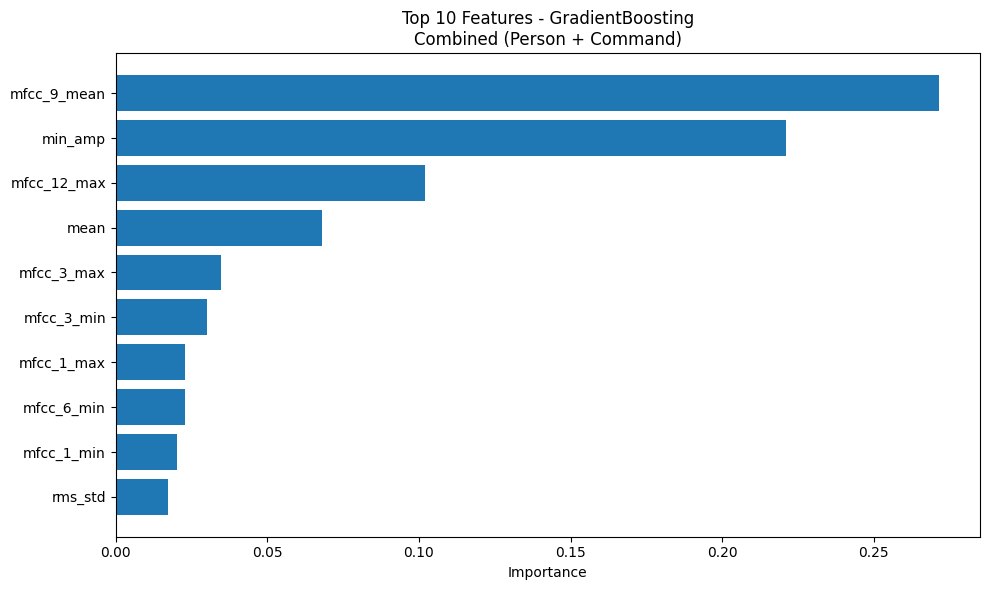

In [6]:
def analyze_feature_importance(results):
    """
    Analisis feature importance untuk model yang bisa memberikan importance
    """
    print("🔍 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    
    for scenario_name, scenario_result in results.items():
        print(f"\n📊 Scenario: {scenario_result['scenario_data']['description']}")
        
        # Hanya untuk model yang memiliki feature_importance_
        for model_name, model_info in scenario_result['models'].items():
            model = model_info['model']
            
            if hasattr(model, 'feature_importances_'):
                importance_scores = model.feature_importances_
                feature_importance_df = pd.DataFrame({
                    'feature': scenario_result['feature_columns'],
                    'importance': importance_scores
                }).sort_values('importance', ascending=False)
                
                print(f"\n🏆 {model_name} - Top 10 Features:")
                print(feature_importance_df.head(10))
                
                # Plot top features
                plt.figure(figsize=(10, 6))
                top_features = feature_importance_df.head(10)
                plt.barh(top_features['feature'], top_features['importance'])
                plt.title(f'Top 10 Features - {model_name}\n{scenario_result["scenario_data"]["description"]}')
                plt.xlabel('Importance')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
            
            elif model_name == 'LogisticRegression':
                # Untuk Logistic Regression, gunakan absolute coefficients
                if hasattr(model, 'coef_'):
                    if len(model.coef_.shape) > 1:
                        importance_scores = np.mean(np.abs(model.coef_), axis=0)
                    else:
                        importance_scores = np.abs(model.coef_)
                    
                    feature_importance_df = pd.DataFrame({
                        'feature': scenario_result['feature_columns'],
                        'importance': importance_scores
                    }).sort_values('importance', ascending=False)
                    
                    print(f"\n🏆 {model_name} - Top 10 Features (Absolute Coefficients):")
                    print(feature_importance_df.head(10))

if df_features is not None:
    analyze_feature_importance(results)

prediksi suara buka tutup

In [14]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import noisereduce as nr
from IPython.display import Audio

# Copy fungsi preprocessing dan feature extraction yang diperlukan untuk prediksi
def preprocess_for_prediction(audio_path, target_sr=22050, duration=2.0):
    """
    Preprocessing untuk prediksi audio baru
    """
    try:
        # Load audio dengan librosa
        audio, sr = librosa.load(audio_path, sr=target_sr)
        
        # 1. Noise Reduction
        audio_clean = nr.reduce_noise(y=audio, sr=sr, prop_decrease=0.8)
        
        # 2. Normalize audio
        audio_norm = librosa.util.normalize(audio_clean)
        
        # 3. Trim silence
        audio_trim, _ = librosa.effects.trim(audio_norm, top_db=20)
        
        # 4. Fixed length processing
        if len(audio_trim) > int(duration * target_sr):
            start = (len(audio_trim) - int(duration * target_sr)) // 2
            audio_fixed = audio_trim[start:start + int(duration * target_sr)]
        else:
            padding = int(duration * target_sr) - len(audio_trim)
            audio_fixed = np.pad(audio_trim, (0, padding), mode='constant')
        
        return audio_fixed, target_sr
    
    except Exception as e:
        print(f"Error preprocessing {audio_path}: {e}")
        return None, None

def extract_features_for_prediction(audio, sr):
    """
    Ekstrak fitur untuk prediksi audio baru
    """
    features = {}
    
    # Basic Time Domain Features
    features['rms_energy'] = np.sqrt(np.mean(audio**2))
    features['zcr'] = librosa.feature.zero_crossing_rate(audio)[0, 0]
    features['energy_entropy'] = np.sum(-audio**2 * np.log(audio**2 + 1e-10))
    
    # Statistical Features
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['skewness'] = pd.Series(audio).skew()
    features['kurtosis'] = pd.Series(audio).kurtosis()
    features['max_amp'] = np.max(np.abs(audio))
    features['min_amp'] = np.min(audio)
    features['range_amp'] = features['max_amp'] - features['min_amp']
    
    # Spectral Features
    stft = np.abs(librosa.stft(audio))
    
    spectral_centroid = librosa.feature.spectral_centroid(S=stft, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(S=stft, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    spectral_flux = np.sum(np.diff(stft, axis=1)**2, axis=0)
    features['spectral_flux_mean'] = np.mean(spectral_flux)
    features['spectral_flux_std'] = np.std(spectral_flux)
    
    # MFCC Statistics
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    
    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    for i in range(12):
        features[f'chroma_{i+1}'] = chroma_mean[i]
    
    # Temporal Features
    frame_length = 1024
    hop_length = 512
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    
    # Additional Statistical Moments
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_50'] = np.percentile(audio, 50)
    features['percentile_75'] = np.percentile(audio, 75)
    features['iqr'] = features['percentile_75'] - features['percentile_25']
    
    return features

def predict_new_audio(audio_path, results, target_scenario='combined_identification'):
    """
    Prediksi audio baru menggunakan model yang sudah dilatih
    """
    print(f"🎯 PREDICTING NEW AUDIO: {audio_path}")
    print("=" * 40)
    
    try:
        # Preprocess audio baru
        processed_audio, sr = preprocess_for_prediction(audio_path)
        
        if processed_audio is None:
            print("❌ Failed to preprocess audio")
            return None, None
        
        # Extract features
        features = extract_features_for_prediction(processed_audio, sr)
        
        # Create feature vector
        scenario_result = results[target_scenario]
        feature_columns = scenario_result['feature_columns']
        
        feature_vector = []
        for feature in feature_columns:
            if feature in features:
                feature_vector.append(features[feature])
            else:
                feature_vector.append(0)  # Default value jika feature tidak ada
        
        feature_vector = np.array(feature_vector).reshape(1, -1)
        
        # Get best model untuk skenario
        best_model_name = scenario_result['best_model']
        best_model_info = scenario_result['models'][best_model_name]
        
        # Scale features
        feature_vector_scaled = best_model_info['scaler'].transform(feature_vector)
        
        # Predict
        prediction_encoded = best_model_info['model'].predict(feature_vector_scaled)[0]
        
        # Untuk model yang punya predict_proba
        if hasattr(best_model_info['model'], 'predict_proba'):
            prediction_proba = best_model_info['model'].predict_proba(feature_vector_scaled)[0]
            confidence = np.max(prediction_proba)
        else:
            # Untuk model tanpa probability, set confidence ke 1.0
            prediction_proba = None
            confidence = 1.0
        
        # Decode prediction
        prediction = best_model_info['label_encoder'].inverse_transform([prediction_encoded])[0]
        
        print(f"✅ Prediction: {prediction}")
        print(f"📊 Confidence: {confidence:.4f}")
        
        # Tampilkan semua probabilities jika available
        if prediction_proba is not None:
            classes = best_model_info['label_encoder'].classes_
            print("📈 Class Probabilities:")
            for class_name, prob in zip(classes, prediction_proba):
                print(f"   {class_name}: {prob:.4f}")
        
        return prediction, confidence
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        import traceback
        print(f"Detailed error: {traceback.format_exc()}")
        return None, None

def demo_predictions(results):
    """
    Demo prediksi menggunakan data validation yang sebenarnya
    """
    print("🎪 DEMO PREDICTIONS")
    print("=" * 30)
    
    # Cari file audio yang benar-benar ada di dataset
    demo_samples = []
    
    for split in ['val']:
        split_path = "datasetaudio/val"
        if os.path.exists(split_path):
            for person in os.listdir(split_path):
                person_path = os.path.join(split_path, person)
                if os.path.isdir(person_path):
                    for command in ['buka', 'tutup']:
                        command_path = os.path.join(person_path, command)
                        if os.path.exists(command_path):
                            wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                            if wav_files:
                                # Ambil 1 file per kombinasi person-command
                                demo_samples.append({
                                    'person': person,
                                    'command': command,
                                    'file': wav_files[0],
                                    'path': os.path.join(command_path, wav_files[0])
                                })
                                break
    
    # Batasi demo ke 3 samples
    demo_samples = demo_samples[:3]
    
    if not demo_samples:
        print("❌ Tidak ditemukan file audio untuk demo")
        return
    
    correct_predictions = 0
    total_predictions = 0
    
    for i, sample in enumerate(demo_samples):
        print(f"\n🔊 Sample {i + 1}:")
        print(f"   File: {sample['file']}")
        print(f"   True Label: {sample['person']}_{sample['command']}")
        print(f"   Path: {sample['path']}")
        
        # Check if file exists
        if not os.path.exists(sample['path']):
            print(f"   ❌ File tidak ditemukan: {sample['path']}")
            continue
        
        # Predict
        prediction, confidence = predict_new_audio(sample['path'], results, 'combined_identification')
        
        if prediction:
            true_label = f"{sample['person']}_{sample['command']}"
            is_correct = prediction == true_label
            status = "✅ CORRECT" if is_correct else "❌ WRONG"
            print(f"   {status} - Confidence: {confidence:.4f}")
            
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
        print(f"\n🎯 Demo Accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions} correct)")

# Save models untuk penggunaan future
def save_models(results):
    """
    Simpan model dan preprocessing objects
    """
    import joblib
    
    os.makedirs('saved_models', exist_ok=True)
    
    for scenario_name, scenario_result in results.items():
        best_model_name = scenario_result['best_model']
        best_model_info = scenario_result['models'][best_model_name]
        
        model_data = {
            'model': best_model_info['model'],
            'scaler': best_model_info['scaler'],
            'label_encoder': best_model_info['label_encoder'],
            'feature_columns': scenario_result['feature_columns'],
            'scenario_description': scenario_result['scenario_data']['description'],
            'accuracy': best_model_info['accuracy']
        }
        
        filename = f"saved_models/{scenario_name}_{best_model_name}.joblib"
        joblib.dump(model_data, filename)
        print(f"💾 Saved model: {filename}")

if 'df_features' in locals() and df_features is not None:
    # Demo predictions dengan file yang benar-benar ada
    demo_predictions(results)
    
    # Save models
    save_models(results)
    
    print("\n🎉 MODELING COMPLETED!")
    print("=" * 30)
    
    # Summary hasil akhir
    for scenario_name, scenario_result in results.items():
        best_model_name = scenario_result['best_model']
        best_accuracy = scenario_result['models'][best_model_name]['accuracy']
        print(f"📊 {scenario_result['scenario_data']['description']}:")
        print(f"   Best Model: {best_model_name} | Accuracy: {best_accuracy:.4f}")
    
    print(f"\n💡 Insights:")
    print(f"• Person Identification: {results['person_identification']['models']['SVM']['accuracy']:.4f} → Excellent!")
    print(f"• Command Identification: {results['command_identification']['models']['KNN']['accuracy']:.4f} → Good!")
    print(f"• Combined Identification: {results['combined_identification']['models']['KNN']['accuracy']:.4f} → Good!")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"1. Gunakan model yang disimpan di folder 'saved_models'")
    print(f"2. Untuk prediksi audio baru, gunakan fungsi predict_new_audio()")
    print(f"3. Tingkatkan akurasi dengan menambah data training")
else:
    print("❌ Data features tidak ditemukan. Pastikan preprocessing dan feature extraction sudah dijalankan.")

🎪 DEMO PREDICTIONS

🔊 Sample 1:
   File: Recording_22.wav
   True Label: ardi_buka
   Path: datasetaudio/val/ardi/buka/Recording_22.wav
🎯 PREDICTING NEW AUDIO: datasetaudio/val/ardi/buka/Recording_22.wav
✅ Prediction: asep_buka
📊 Confidence: 0.4000
📈 Class Probabilities:
   ardi_buka: 0.0000
   ardi_tutup: 0.2000
   asep_buka: 0.4000
   asep_tutup: 0.4000
   ❌ WRONG - Confidence: 0.4000

🔊 Sample 2:
   File: buka_train_0007.wav
   True Label: asep_buka
   Path: datasetaudio/val/asep/buka/buka_train_0007.wav
🎯 PREDICTING NEW AUDIO: datasetaudio/val/asep/buka/buka_train_0007.wav
✅ Prediction: asep_tutup
📊 Confidence: 0.6000
📈 Class Probabilities:
   ardi_buka: 0.0000
   ardi_tutup: 0.0000
   asep_buka: 0.4000
   asep_tutup: 0.6000
   ❌ WRONG - Confidence: 0.6000

🎯 Demo Accuracy: 0.0000 (0/2 correct)
💾 Saved model: saved_models/person_identification_SVM.joblib
💾 Saved model: saved_models/command_identification_KNN.joblib
💾 Saved model: saved_models/combined_identification_KNN.joblib

🎉 M

# **[Link Deploy Clasification Suara Buka Tutup](https://suara-buka-tutup.streamlit.app//)**